In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
import multiprocessing as mp

In [2]:
# jupyter notebook settings for debugging
%load_ext autoreload
%autoreload 2

In [74]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist
from statmechlib.preprocessing import force_targ, get_stats_EAM_per_atom, get_stats_EAM_per_box

In [5]:
# Define locations of relevant datasets

target_raw = '../data/re/target_raw'
target_proc = '../data/re/target_processed'
working = '../data/re/working'
reports = '../reports/'

# MD trajectories
datasets_MD = ['hcp_npt_langevin_300K',
            #'fcc_npt_langevin_300K',
            #'vac_npt_langevin_2000K',
            #'i110_npt_langevin_2000K',
            #'i111_npt_langevin_2000K',
            #'screw_111_npt_langevin_2000K',
            'hcp_npt_langevin_3700K',
            'liq_3700K',
            'liq_2_3700K']

# 0K relaxed structures
# datasets_0k = ['bcc_0k',
#                'fcc_0k',
#                'vac_0k',
#                'i110_0k',
#                'i111_0k',
#                'screw_111_0k'
#                 ]

# equations of state for BCC and FCC lattices
configs = ['v0.8','v0.9','v1.0','v1.1','v1.2','v1.3','v1.4','v1.5']

datasets_eos_hcp = ['eq_st_hcp/' + s for s in configs]
#datasets_eos_fcc = ['eq_st_fcc/' + s for s in configs]

# bain path
# configs = ['1.00', '1.05', '1.10', '1.15', '1.20', '1.25', '1.30', '1.35', '1.40', '1.45', '1.50', '1.55']

#datasets_bain = ['bain_path/' + s for s in configs]

# vacancy interactions

# configs = ['v2_r1', 'v2_r2', 'v2_r3', 'v3_1_555', 'v3_3_555', 'v4_2_555', 'v4_5_555', 'v5_555', 'v6_555', 'v6_6x6x6_360']#, 'prf_360']

# datasets_vacint = ['vacint/' + s for s in configs]

# defined dataset directories relative to the current directory (/notebooks)
trajdirs_MD = [target_raw + '/' + dataset for dataset in datasets_MD]
#trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]
trajdirs_eos_hcp = [target_raw + '/' + dataset for dataset in datasets_eos_hcp]
#trajdirs_eos_fcc = [target_raw + '/' + dataset for dataset in datasets_eos_fcc]
#trajdirs_bain = [target_raw + '/' + dataset for dataset in datasets_bain]
#trajdirs_vacint = [target_raw + '/' + dataset for dataset in datasets_vacint]

In [9]:
%%time

# set up a multiprocessing pool
pool = mp.Pool()

# # read vacancy interactins in parallel
# output_data = pool.map(read_vasp, trajdirs_vacint)
# trajectories_vacint = dict(zip(datasets_vacint, output_data))
# print('Done with vacint')

# read MD trajectories in parallel
output_data = pool.map(read_vasp, trajdirs_MD)
trajectories_MD = dict(zip(datasets_MD, output_data))
print('Done with MD')

# # read 0K configurations in parallel
# output_data = pool.map(read_vasp, trajdirs_0k)
# trajectories_0k = dict(zip(datasets_0k, output_data))
# print('Done with 0k')

# read HCP EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_hcp)
trajectories_eos_hcp = dict(zip(datasets_eos_hcp, output_data))
print('Done with HCP EOS')

# # read BCC EOS in parallel
# output_data = pool.map(read_vasp, trajdirs_eos_fcc)
# trajectories_eos_fcc = dict(zip(datasets_eos_fcc, output_data))
# print('Done with FCC EOS')

# # read bain path in parallel
# output_data = pool.map(read_vasp, trajdirs_bain)
# trajectories_bain = dict(zip(datasets_bain, output_data))
# print('Done with bain path')

pool.close()
pool.join()

Done with HCP EOS
CPU times: user 13.3 ms, sys: 26.8 ms, total: 40 ms
Wall time: 245 ms


In [12]:
# Convert MD trajectory dicts to objects
trjs_MD = {}
for k, trj in trajectories_MD.items():
    trjs_MD[k] = Trajectory(trj, inplace=False)
    
# # Convert 0K configs to objects
# trjs_0k = {}
# for k, trj in trajectories_0k.items():
#     trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

# Convert bcc eos configs to objects
trjs_eos_hcp = {}
for k, trj in trajectories_eos_hcp.items():
    trjs_eos_hcp[k] = Trajectory(trj, inplace=False)[-1]
    
# # Convert fcc eos configs to objects
# trjs_eos_fcc = {}
# for k, trj in trajectories_eos_fcc.items():
#     trjs_eos_fcc[k] = Trajectory(trj, inplace=False)[-1]
    
# # Convert bain path configs to objects
# trjs_bain = {}
# for k, trj in trajectories_bain.items():
#     trjs_bain[k] = Trajectory(trj, inplace=False)[-1]
    
# # Convert vacint configs to objects
# trjs_vacint = {}
# for k, trj in trajectories_vacint.items():
#     trjs_vacint[k] = Trajectory(trj, inplace=False)[-1]

In [79]:
# plt.figure(figsize=(20,10))
# ratio = [trjs_bain[key]['box'][0][2,2]/trjs_bain[key]['box'][0][0,0] for key in datasets_bain]
# plt.plot(ratio, np.array([trjs_bain[key]['energy'] for key in datasets_bain])/128.- trjs_bain['bain_path/1.00']['energy'][-1]/128.)
# plt.xlim(1.0, 1.95)
# plt.grid(True)

In [80]:
# plt.figure(figsize=(20,10))
# #ratio = [trjs_vacint[key]['box'][0][2,2]/trjs_bain[key]['box'][0][0,0] for key in datasets_bain]
# plt.title('Vacancy cluster formation energies')
# nat = np.array([len(trjs_vacint[key]['xyz'][-1]) for key in sorted(datasets_vacint)])
# enes_big =   [trjs_vacint[key]['energy'][-1] + 5598.713470/432*nat[i] for i, key in enumerate(sorted(datasets_vacint))]
# enes_small = [trjs_vacint[key]['energy'][-1] + 3239.858169/250*nat[i] for i, key in enumerate(sorted(datasets_vacint))]

# #plt.plot(np.array([trjs_vacint[key]['energy'][-1] for key in datasets_vacint])/nat - 8.9)
# #plt.xlim(1.0, 1.95)
# plt.grid(True)
# plt.plot(enes_big)
# plt.plot(enes_small)
# #plt.plot(np.array([trjs_vacint[key]['energy'][-1] for key in sorted(datasets_vacint)]) - trjs_0k['bcc_0k']['energy'][-1]/128.*nat)
# x_ticks = (list(range(len(trjs_vacint.keys()))), sorted(list(trjs_vacint.keys())))
# plt.xticks(*x_ticks)


# print([trjs_vacint[key]['energy'][-1] + 5598.713470/432*nat[i] for i, key in enumerate(sorted(datasets_vacint))])
# print([trjs_vacint[key]['energy'][-1] + 3239.858169/250*nat[i] for i, key in enumerate(sorted(datasets_vacint))])
# print(nat)

In [24]:
# Join relaxed configurations into pseudo-trajectories

# # join 0 K configurations into a pseudo-trajectory
# traj_0k = copy.deepcopy(trjs_0k['bcc_0k'])
# for k, trj in sorted(trjs_0k.items()):
#     if 'bcc_0k' not in k:
#         traj_0k.append(trj)

# join eos bcc configurations into a pseudo-trajectory
traj_eos_hcp = copy.deepcopy(trjs_eos_hcp['eq_st_hcp/v0.8'])
for k, trj in sorted(trjs_eos_hcp.items()):
    if k != 'eq_st_hcp/v0.8':
        traj_eos_hcp.append(trj)

# # join eos fcc configurations into a pseudo-trajectory
# traj_eos_fcc = copy.deepcopy(trjs_eos_fcc['eq_st_fcc/v0.8'])
# for k, trj in sorted(trjs_eos_fcc.items()):
#     if k != 'eq_st_fcc/v0.8':
#     #if ('v0.8' in k) or ('v0.9' in k) or ('v1.1' in k) or ('v1.2' in k):
#         traj_eos_fcc.append(trj)
        
# # join bain path configurations into a pseudo-trajectory
# traj_bain = copy.deepcopy(trjs_bain['bain_path/1.00'])
# for k, trj in sorted(trjs_bain.items()):
#     if k != 'bain_path/1.00':
#         traj_bain.append(trj)
        
# # join vacint configurations into a pseudo-trajectory
# traj_vacint = copy.deepcopy(trjs_vacint['vacint/v2_r1'])
# for k, trj in sorted(trjs_vacint.items()):
#     if k != 'vacint/v2_r1':
#         traj_vacint.append(trj)

In [25]:
# Create a dictionary of trajectories
trjs = {}
trjs.update(trjs_MD)
#trjs['relax'] = traj_0k
trjs['eos_hcp'] = traj_eos_hcp
# trjs['eos_fcc'] = traj_eos_fcc
# trjs['bain'] = traj_bain
# trjs['vacint'] = traj_vacint

In [76]:
# shift zero of energy to by subtracting intra-atomic contributions (energy of an isolated atom)
n_atoms_hcp = len(trjs['hcp_npt_langevin_300K']['xyz'][0])
u_box = trjs['hcp_npt_langevin_300K']['energy'][0]

u_atom = u_box/n_atoms_hcp
u_lattice = -8.03 # experimental lattice energy of a BCC lattice
#u_lattice = -8.89965188
u_intra = u_atom - u_lattice # internal energy per atom (to be subtracted from all atoms)

for key, trj_i in trjs.items():
    #print(key, type(trj_i))
    trj_i.set_zero_energy(u_intra, inplace=True)

In [117]:
#trjs['hcp_npt_langevin_300K'][0]
#u_atom, u_lattice, u_intra, trjs['relax']['energy'], trjs['vacint']['energy']

In [80]:
#np.array(trjs['relax']['energy'])/np.array([len(x) for x in trjs['relax']['xyz']])

In [81]:
#trjs_0k['bcc_0k']['total_energy'], trjs['relax'][0]['energy']

In [84]:
# Create configurations and energies based on universal equation of state for HCP rhenium
traj_eos = scale_configuration(copy.deepcopy(trjs['hcp_npt_langevin_300K'][0]), 0.5)
for scale in list(np.linspace(0.55, 1.5, 20)):
    traj_scale = copy.deepcopy(trjs['hcp_npt_langevin_300K'][0])
    traj_eos.append(scale_configuration(traj_scale, scale, system='Re'))

trjs['eos'] = traj_eos

In [85]:
# Create an artificial 'infinite' configuration with large box and 0 energy
#traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])
traj_inf = copy.deepcopy(trjs['hcp_npt_langevin_300K'][0])
traj_inf = scale_configuration(traj_inf, 100.0)
trjs['inf'] = traj_inf

In [86]:
# Set temperature to 300 K (for convenience)
pseudo_trajs = ['relax', 'bain', 'vacint', 'eos_bcc', 'eos', 'eos_fcc', 'inf']
pseudo_trajs = ['eos_hcp', 'eos', 'inf']

for key in pseudo_trajs:
    trjs[key]['temp'] = [300.0 for _ in range(len(trjs[key]['energy']))]

In [87]:
trjs.keys()

dict_keys(['hcp_npt_langevin_300K', 'hcp_npt_langevin_3700K', 'liq_3700K', 'liq_2_3700K', 'eos_hcp', 'eos', 'inf'])

[1806.3258, 2931.6584000000003, 8955.0342, 9616.5888, 9645.7313, 9532.6674, 9532.9708, 9430.5171]
[47651.84963368314, 34801.24521449396, 19946.98680403133, 10984.436927557299, 5668.986084441145, 2586.919967732285, 855.1277311077654, -72.94977937596869, -531.9990095220655, -724.4365292942825, -770.8799999999999, -741.9023248262215, -677.838183745981, -601.0184784912948, -523.2439734381832, -450.29240354679365, -384.595779231272, -326.80210305699285, -276.66606787818546, -233.5425290969097, -196.64930893315397]


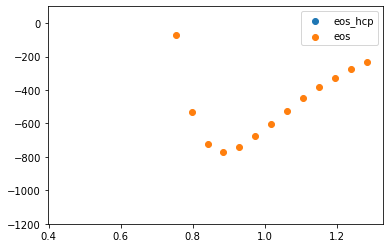

In [90]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    if 'eos' in key:
        plt.scatter([np.linalg.det(b)**(1./3.)/12.744894 for b in trj['box']][:-1], trj['energy'][:-1], label=key)
        print(trj['energy'][:])
plt.legend()
#plt.xlim(-1780,-1100)
plt.ylim(-1200,100)
plt.show()

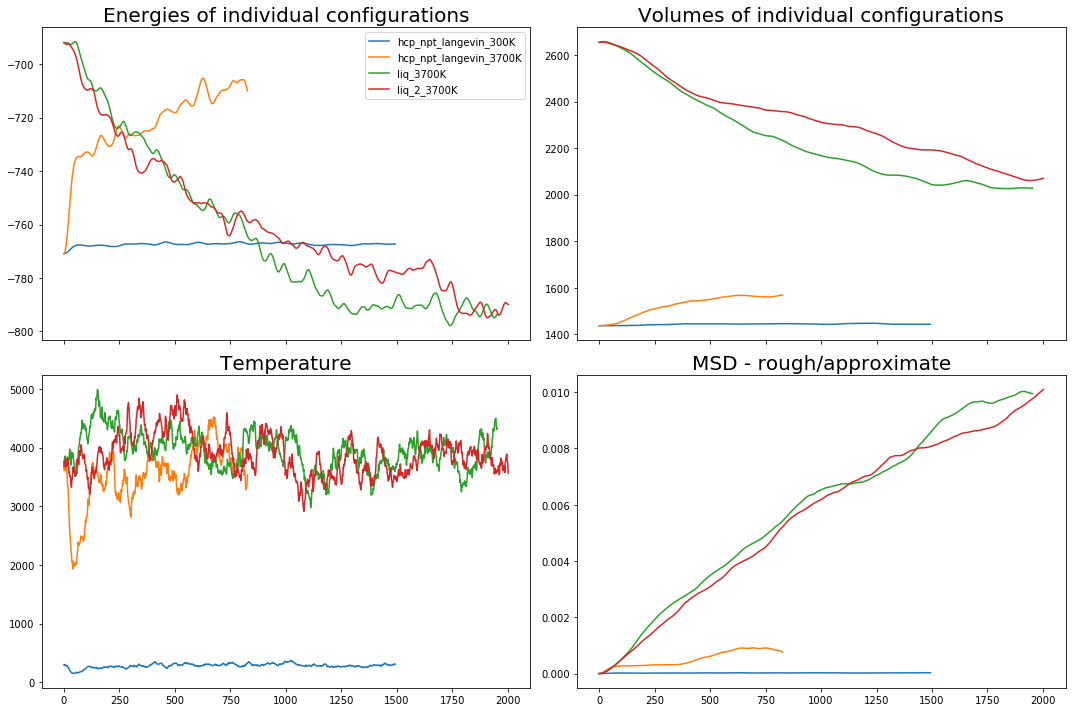

In [93]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
        
    if 'relax' in key or 'eos' in key or 'vacint' in key or 'inf' in key:
        continue

    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

#print([128*128/np.linalg.det(b) for b in trjs['relax']['box']])

In [92]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('hcp_npt_langevin_300K', 1494),
 ('hcp_npt_langevin_3700K', 828),
 ('liq_3700K', 1954),
 ('liq_2_3700K', 2003),
 ('eos_hcp', 8),
 ('eos', 21),
 ('inf', 1)]

In [99]:
slices = {'hcp_npt_langevin_300K':slice(250, None,3),
#         'fcc_npt_langevin_300K':slice(50, None, 4),
#         'vac_npt_langevin_2000K':slice(300, None, 5),
#         'i110_npt_langevin_2000K':slice(800, None, 5),
#         'i111_npt_langevin_2000K':slice(800, None, 5),
#         'screw_111_npt_langevin_2000K':slice(1000, None, 5),
        'hcp_npt_langevin_3700K':slice(300, None, 3),
        'liq_3700K':slice(1250, None, 3),
        'liq_2_3700K':slice(1250, None, 3),
#         'relax':slice(0, None, None),
        'eos_hcp':slice(0, None, None),
#         'eos_fcc':slice(0, None, None),
        'eos':slice(0, None, None),
#         'bain':slice(0, None, None),
#         'vacint':slice(0, None, None),
        'inf':slice(0, None, None)
       }

In [100]:
trj_samples = {}
for key, traj in trjs.items():
    trj_samples[key] = traj[slices[key]]

In [101]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('hcp_npt_langevin_300K', 415),
 ('hcp_npt_langevin_3700K', 176),
 ('liq_3700K', 235),
 ('liq_2_3700K', 251),
 ('eos_hcp', 8),
 ('eos', 21),
 ('inf', 1)]

In [102]:
trj_samples['liq_3700K'].append(trj_samples['liq_2_3700K'])

In [103]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('hcp_npt_langevin_300K', 415),
 ('hcp_npt_langevin_3700K', 176),
 ('liq_3700K', 486),
 ('liq_2_3700K', 251),
 ('eos_hcp', 8),
 ('eos', 21),
 ('inf', 1)]

In [104]:
del trj_samples['liq_2_3700K']

In [105]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('hcp_npt_langevin_300K', 415),
 ('hcp_npt_langevin_3700K', 176),
 ('liq_3700K', 486),
 ('eos_hcp', 8),
 ('eos', 21),
 ('inf', 1)]

In [96]:
# # join all MD configurations into a pseudo-trajectory (to properly weigh phase stability)
# traj_md = copy.deepcopy(trj_samples['bcc_npt_langevin_300K'])

# for k, trj in sorted(trj_samples.items()):
#     print(k)
#     if 'vacint' in k or 'bain' in k or 'eos' in k or 'relax' in k or 'bcc_npt_langevin_300K' in k: 
#         continue
        
#     traj_md.append(trj)

#     print(len(traj_md['box']))

# # add inf configurations at the end to define zero of potential energy
# traj_inf_md = copy.deepcopy(traj_inf)
# traj_inf_md['ensemble'] = 'md'
# for i in range(200):
#     traj_md.append(traj_inf_md)

In [106]:
# trj_samples['eos_hcp']['energy']

[1806.3258,
 2931.6584000000003,
 8955.0342,
 9616.5888,
 9645.7313,
 9532.6674,
 9532.9708,
 9430.5171]

In [108]:
with open(os.path.join(working, "trj_all_samples.pickle"), 'wb') as fo:
    pickle.dump(trj_samples, fo)#, protocol=2)

(-1000, 0)

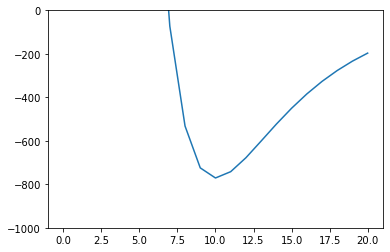

In [114]:
plt.plot(trj_samples['eos']['energy'])
plt.ylim(-1000, 0)

In [116]:
# from statmechlib.preprocessing import find_min_distance
# print('Minimum distance:', find_min_distance(trj_samples))

NameError: name 'pair_dist' is not defined